In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')

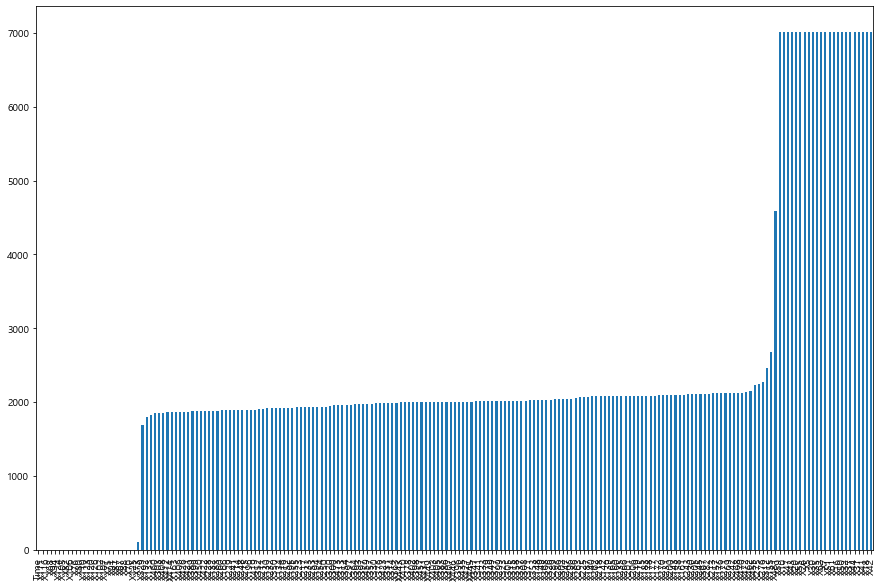

In [5]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

In [6]:
##### train 결측치 채우기

> 직전시간대의 전력수요량이 과다측정된경우의 결측값 처리

In [7]:
for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중
250 번째 실행중
300 번째 실행중
350 번째 실행중
400 번째 실행중
450 번째 실행중
500 번째 실행중
550 번째 실행중
600 번째 실행중
650 번째 실행중
700 번째 실행중
750 번째 실행중
800 번째 실행중
850 번째 실행중
900 번째 실행중
950 번째 실행중
1000 번째 실행중
1050 번째 실행중
1100 번째 실행중
1150 번째 실행중
1200 번째 실행중
1250 번째 실행중
1300 번째 실행중


In [ ]:
for k in range(1,len(test.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    test_median=test.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=test.loc[ test.iloc[:,k].isnull()==False ][ test.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if test.iloc[i,k]>=test_median: #현재 indetestx에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            test.iloc[ i : i+j+1 , k] = test.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

In [ ]:
train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

> 1,2차 결측치 처리 후 온전한 데이터인 2/15일 이후 부터의 데이터로 모델링 진행

In [ ]:
train_sample = train['2018-02-15':]
train_sample = train_sample.interpolate(method='time')

test_sample = test['2018-02-15':]
test_sample = test_sample.interpolate(method='time')

In [ ]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

In [ ]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
test_sample.loc[:,test_sample.isnull().sum() >= 1].columns

In [ ]:
train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

test_sample.drop(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],axis=1,inplace=True)

> 시계열 패턴 분류 및 분석을 위한 데이터 전처리 <br>
> tslearn 패키지 사용 kmeans.cluster 사용

In [ ]:
tmp_list = []

for i in range(len(train_sample.columns)):
    tmp_list.append(train_sample.iloc[:,i].values)

to_formatted = np.array(tmp_list)

formatted = to_time_series_dataset(to_formatted)

In [ ]:
to_formatted

In [ ]:
formatted

> train_sample 데이터를 10개의 군집으로 분류

In [ ]:
km = TimeSeriesKMeans(n_clusters=50,verbose=True,n_init=10,random_state=0)
y_pred = km.fit_predict(formatted)

> 분류된 trains_sample 데이터의 군집별 패턴 파악

In [ ]:
plt.figure(figsize=(12,8))
for yi in range(30):
    plt.subplot(30,1, yi+1)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")

In [ ]:
# predict = pd.DataFrame(km.predict(formatted))
# predict.columns=['predict']

In [ ]:
data = {'target' : train_sample.columns,
       'cluster' : km.predict(formatted)
       }

cluster_frame = pd.DataFrame(data)

In [ ]:
cluster_frame.head()

In [ ]:
# 군집별 갯수 파악
cluster_frame.groupby('cluster').size()

> 0 군집을 대상으로 모델링 진행

In [ ]:
cluster_0 = cluster_frame[cluster_frame.cluster ==8]['target'].values

> train_sample의 패턴별 군집에 맞추어 test 세대를 군집 분류 <br>
> train세대와 test세대는 서로 다른 세대임(중복x)

In [ ]:
## cluster test set

In [ ]:
tmp_test_list = []

for i in range(len(test_sample.columns)):
    tmp_test_list.append(test_sample.iloc[:,i].values)

to_test_formatted = np.array(tmp_test_list) # tslearn input 형식으로 

test_formatted = to_time_series_dataset(to_test_formatted)

In [ ]:
data = {'target' : test_sample.columns,
       'cluster' : km.predict(test_formatted)
       }

cluster_test_frame = pd.DataFrame(data)

In [ ]:
# 군집별 개수 파악
cluster_test_frame.groupby('cluster').size()

In [ ]:
cluster_test_0 = cluster_test_frame[cluster_test_frame.cluster == 8]['target'].values

In [ ]:
# 군집별 모델 생성

In [ ]:
# RNN 네트워크에 input 형식으로 넣기위한 과정 
# RNN의 input shape은 (timestep,feature)

def to_X_train(target):
    
    train_sc_df = pd.DataFrame(target , columns=['Scaled'], index=train_sample.index)
    for s in range(1, 7):
        train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    X_train = train_sc_df.dropna().drop('Scaled', axis=1)
    y_train = train_sc_df.dropna()[['Scaled']]    
    X_train = X_train.values
    y_train = y_train.values
    
    X_train_s = X_train.reshape(X_train.shape[0], 6, 1) # 6 기간의 시간씩, feature는 전력수요량 1차원
    return X_train_s,y_train 
    

In [ ]:
ss = []
for idx,k in enumerate(cluster_0):
    x,y = to_X_train(train_sample[k].values)
    ss.append([x,y])

In [ ]:
#####################################################

In [ ]:
def to_X_test(target):
    
    test_sc_df = pd.DataFrame(target , columns=['Scaled'], index=test_sample.index)
    for s in range(1, 7):
        test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    X_test = test_sc_df.dropna().drop('Scaled', axis=1)
    y_test = test_sc_df.dropna()[['Scaled']]    
    X_test = X_test.values
    y_test = y_test.values
    
    X_test_t = X_test.reshape(X_test.shape[0], 6, 1)
    return X_test_t,y_test


ss_test = []
for idx,k in enumerate(cluster_test_0):
    x,y = to_X_test(test_sample[k].values)
    ss_test.append([x,y])

In [ ]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
K.clear_session()

model = Sequential() # Sequeatial Model 
model.add(LSTM(32, input_shape=(6, 1),return_sequences=True)) # (timestep, feature)
# model.add(Dropout(0.1)) # overfitting을 막기 위해 10% 가량 drop
model.add(LSTM(32, input_shape=(6, 1))) # (timestep, feature)
# model.add(Dropout(0.1)) # overfitting을 막기 위해 10% 가량 drop
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

In [ ]:
# 모델 학습
early_stop = EarlyStopping(monitor='loss', patience=7, verbose=1)

for i in range(3):
    history = model.fit(ss[i][0],ss[i][1], epochs=30, batch_size=52, verbose=1, callbacks=[early_stop])

# history = model.fit(ss[0][0],ss[0][1], epochs=30, batch_size=52, verbose=0, callbacks=[early_stop])

In [ ]:
results = model.evaluate(ss_test[3][0],ss_test[3][1])
results

In [ ]:
y_pred = model.predict(ss_test[3][0])
print(y_pred)

In [ ]:
plt.figure()
plt.plot(res_test_y)